# Solving a System of First Order ODEs with a PINN

A good way to see how to implement a Physics-Informed Neural Network (PINN) to solve a physics-based problem that involves a system of equations, is to do so by example.  After watching this example [1], I created my own Jupyter notebook to replicate that work and continue past it.  The corresponding sysEqns.py file is in work and will be the place where I incorporate the things I learned from this notebook.

[1] https://www.youtube.com/watch?v=gXv1SGoL04c

**Outline**
1. [PINN background](#PINN)
2. [PINN python class definition](#PINN-Class)
    1. [Loss function with ODEs and ICs](#Loss)
    2. [Training function with previous loss definition](#training-function)
    2. [Execute PINN training](#set-up-the-steps-and-execute)
    2. [Define analytical solution](#define-analytical-solution-for-comparison)
    2. [Visualize](#visualize)
3. [Data fitting with PINN](#data-fitting-with-pinn)
    1. [Generate random noise](#now-generate-random-noise-to-similate-real-data)
    3. [Data loss function](#create-the-data-loss-function)
4. [Define new setup](#new-set-up)
    1. [Train on data](#now-retrain-the-pinn-on-the-provided-data)
    4. [Run the new model](#run-the-model)
    4. [Visualize results](#visualize)
5. [Increase training epochs](#now-increase-the-epochs)
    1. [Visualize](#visualize)
6. [Predict last data point](#predict-last-data-point)
    1. [A PINN for last point prediction](#model-a-pinn-class-to-predict-last-data-point)
    6. [Use sequence sliding input window for allowed training data](#use-sequence-sliding-input-window-for-allowed-training-data)
    6. [Use window data gap to ignore data in training](#use-window-data-gap-to-ignore-data-in-training)
7. [Example probability graph](#example-graph-represent-probabilities)
8. [Perform 2-class classification for last point prediction](#perform-2-class-classification-for-last-point-prediction) To-do!
9. [Expand last point prediction to area prediction](#expand-last-point-prediction-to-area-prediction) To-do!


## PINN
A PINN is a special type of neural network that incorporates the physics within the training process for the neural network.  Traditional neural networks learn to model the data by minimizing a data-fit loss function, but a PINN includes the residuals from the underlying physics differential equations within the loss function.  This allows the PINN model to obey the physics when fitting the data.  The PINN really shines under limited data scenarios because the physics of the equations (ODEs, PDEs) shape the solution.

## Example: A 2-D System of ODEs
Suppose we have these two ODEs and initial conditions (ICs) that describe two coupled harmonic oscillators or electrical circuits for a time domain $t\in [0,5]$:

$$\frac{dx}{dt}=-2x-y$$
$$\frac{dy}{dt}=x-2y$$
$$x(0)=1$$
$$y(0)=0$$

with analytical solutions,

$$x(t)=^1_2\left( e^{-t}+e^{-3t}\right)$$
$$x(t)=^1_2\left( -e^{-t}+e^{-3t}\right)$$

## PINN Key Concept
The idea is to represent the unknown functions $x(t)$ and $y(t)$ as an output of a neural network.  The input of the network is the time $t$ and the network will learn to approximate the functions $x(t)$ and $y(t)$ by minimizing a loss function that includes both of these:
1. The residuals of the ODEs
2. The intial conditions.
By training the neural network to minimize this combined loss, we ensure that the network learns a solution that satisfies both the governing equatinos and the given initial conditions.

## Neural Network Architecture
The NN will have the following structure:
- Input layer with 1 neuron for the input $t$
- Hidden layers with non-linear activation functions (e.g. $Tanh$ or $ReLU$) to learn the underlying structure of the problem
- Output layer to provide the 2 variables we want, $x(t)$ and $y(t)$

The NN will be trained to minimize the residuals of the ODEs and the error in the ICs.

## Loss Function
The most critical part of a NN and especially for the PINN is the way we set up the loss function to satisfy the physics (residuals of the ODEs) and the ICs.
1. ODE Residual Loss
2. IC Loss
The **total loss** is the sum of the two contributions:
$$Total Loss=ODE Residual Loss + IC Loss$$
Variations of the solutions can also include data loss terms and options on how one "adds" the losses, e.g. weighted loss.

### ODE Residual Loss
Rearranging the ODEs so that they sum to zero will put the ODEs into a *residual loss* format as shown here:
$$f_x(t)=\frac{dx}{dt}+2x+y$$
$$f_y(t)=\frac{dy}{dt}-x+2y$$
These are embedded into the PINN as residuals to minimize.  The NN output should minimize the residuals to satisfy the ODEs at each point in the domain $t$.
To measure the residual loss between ODEs and data points, we will use the *mean squared sum error*:
$$MSE(f_x(t))=\frac{1}{N}\sum^N_{i=1}(f_x(t_i))^2$$
$$MSE(f_y(t))=\frac{1}{N}\sum^N_{i=1}(f_y(t_i))^2$$
- The MSE penalizes any deviation of the network's output from satisfying the ODEs.
- The NN is trained to minimize the residuals.

### IC Loss
To satisfy the ICs, we rearrange them into loss terms:
$$IC_x=(x(0)-1)^2 \text{and} IC_y=(y(0)-0)^2=(y(0))^2$$
- The IC losses ensure that the NN solution satisfies the ICs.
- The NN is penalized heavily for not satisfying the ICs.

### Total Loss Function
The *total loss function* is simply the sum of all the losses.  Alternatively, the architect can unequally weight these losses.
$$TLF=MSE(f_x(t))+MSE(f_y(t))+IC_x+IC_y$$
- $MSE_x$ satisfies $f_x(t)$
- $MSE_y$ satisfies $f_y(t)$
- $IC_x$ satisfies $x(0)=1$
- $IC_y$ satisfies $y(0)=0$

## Role of Collection Points
Collection points are specific points ($t_i$) where we enforce ODEs and ICs (and/or BCs).
- These points are siilar to data points in traditional machine learning because we generate the data at these points.
- Ensures the system of ODEs is satisfied throughout the domain.
- Often chosen to be evenly spaced throughout the domain to provide a uniform representation of the problem space.

## Universal Approximation Theorem
The UAT simply states that a simple NN with enough neurons in the hidden layers and suitable activation functions can approximate any continuous function on a closed and bounded interval to any desired level of accuracy.

## Training the NN
The NN is trained by minimizing the total loss function (TLF) during each epoch of training.
1. NN predicts $x$ and $y$ at various $t$
2. $\dot{x}$ and $\dot{y}$ are computed with automatic differentiation
3. The ODE residuals are calculated
4. The TLF is evaluated; gradients are computed to update the NN weights that minimize the TLF (e.g. gradient descent method)
5. Over time (epochs), the NN learns the satisfy the ODEs and the ICs.

## Implementation
1. Define NN architecture
2. Define loss function
3. Train the NN on the data
4. Evaluate the NN outputs
5. Visualize the results

# Python Code
## Imports (system setup)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

## PINN Class

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh()
        )
        self.dense2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh()
        )
        self.dense3 = nn.Linear(64, 2)  # Outputs x(t), y(t)

    def forward(self, t):
        t = self.dense1(t)
        t = self.dense2(t)
        return self.dense3(t)


## Loss 
Key steps:
1. Compute the gradient for NN's estimate of $\frac{dx}{dt}$ and $\frac{dy}{dt}$
2. Compute the ODE residuals

In [3]:
def loss_fn(model, t):
    """ Total Loss Function """
    # Enable gradient tracking
    t.requires_grad_(True)

    # Forward pass
    output = model(t)
    x = output[:, 0:1]
    y = output[:, 1:2]

    # Compute gradients dx/dt and dy/dt
    dxdt = torch.autograd.grad(outputs=x, inputs=t,
                                grad_outputs=torch.ones_like(x),
                                create_graph=True)[0]
    dydt = torch.autograd.grad(outputs=y, inputs=t,
                                grad_outputs=torch.ones_like(y),
                                create_graph=True)[0]

    # Residual ODEs
    res_x = dxdt + 2 * x + y
    res_y = dydt + x + 2 * y

    # Initial Conditions (IC)
    ICx = (x[0] - 1) ** 2
    ICy = (y[0] - 0) ** 2

    # Total loss
    loss = (torch.mean(res_x ** 2) +
            torch.mean(res_y ** 2) +
            ICx + ICy)

    return loss


## Training function
The key steps are:
1. Epoch loop - update the model weights in each epoch
2. Calculate the loss with a goal to exit loop when loss is $\lt 10^{-3}$ or $\lt 10^{-4}$
3. Calculate the gradient of the loss with respect to the NN weights and NN biases
4. Update the optimizer to update the model parameters so that the loss is further reduced
5. Log the progress

In [4]:
def train(model, t, epochs, optimizer):
    for epoch in range(epochs):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the loss
        loss = loss_fn(model, t)
        
        # Backpropagation
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Print loss periodically
        if epoch % 500 == 0:
            print(f"Epoch {epoch} Loss: {loss.item()}")


## Set up the steps and Execute
1. Define our model with the PINN class
2. Define the gradient optimizer, e.g. **Adam**, to control the learning rate for the model's weights during training.
3. Loop the model and optimizer to adjust the model parameters to minimize the loss and ensure the NN satisfies both the physics and the ICs.

In [5]:
# Run our model
model = PINN()

# Define the optimizer
# optimizer = tf.keras.optimizer.Adam(learning_rate=0.001) # control rate
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Control rate

# Define domain (t ∈ [0, 5]) -- "Collection Points"
# t = tf.convert_to_tensor(np.linspace(0,5,100)[:, None], dtype=tf.float32)
t = torch.tensor(np.linspace(0, 5, 100).reshape(-1, 1), dtype=torch.float32)

# Train the model
train(model, t, epochs=4000, optimizer=optimizer)

# Test the model
t_test = torch.tensor(np.linspace(0, 5, 300).reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    predictions = model(t_test)
    x_pred, y_pred = predictions[:, 0].numpy(), predictions[:, 1].numpy()


Epoch 0 Loss: 2.837104320526123
Epoch 500 Loss: 0.0030528907664120197
Epoch 1000 Loss: 0.0003694647748488933
Epoch 1500 Loss: 0.00011915931099792942
Epoch 2000 Loss: 4.627995804185048e-05
Epoch 2500 Loss: 2.4745266273384914e-05
Epoch 3000 Loss: 0.0015067317290231586
Epoch 3500 Loss: 1.3864718312106561e-05


## Define analytical solution for comparison

In [6]:
# Truth solution
def solution(t):
    t = np.asarray(t)  # Ensure it's a standard ndarray
    x_t = 0.5 * (np.exp(-t) + np.exp(-3*t))
    y_t = 0.5 * (-1*np.exp(-t) + np.exp(-3*t))
    return x_t, y_t

# Compare results:
x_true, y_true = solution(t_test)


## Visualize

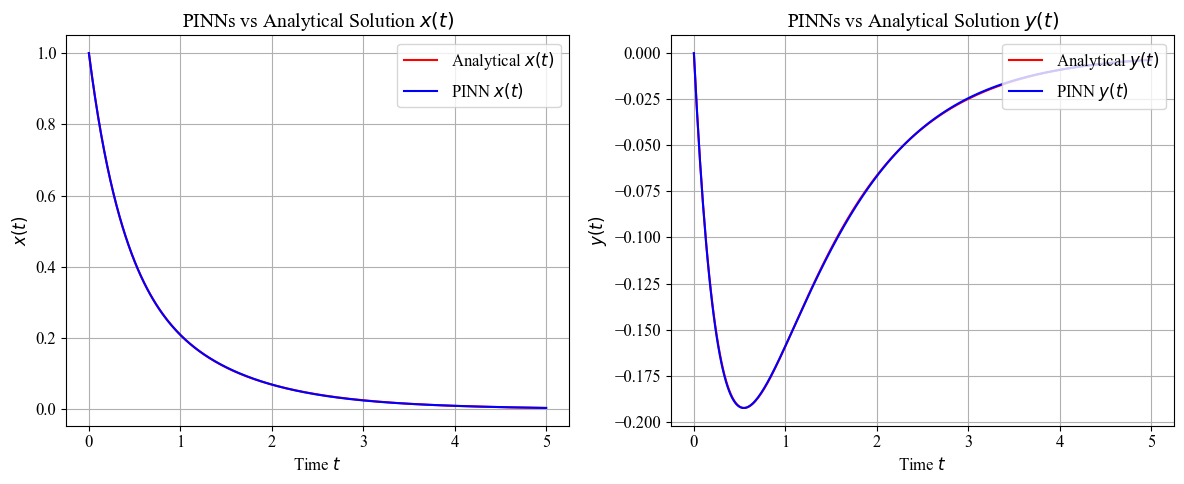

In [7]:
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_test, x_true, label=r'Analytical $x(t)$', color='red')
plt.plot(t_test, x_pred, label=r'PINN $x(t)$', color='blue')
plt.title(r'PINNs vs Analytical Solution $x(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.subplot(1,2,2)
plt.plot(t_test, y_true, label=r'Analytical $y(t)$', color='red')
plt.plot(t_test, y_pred, label=r'PINN $y(t)$', color='blue')
plt.title(r'PINNs vs Analytical Solution $y(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$y(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.tight_layout()
plt.show()

# Data fitting with PINN
## Now generate random noise to similate real data

In [8]:
def generate_noisy_data(t_values, noise_scale=0.05, seed=None):
    """
    Generates noisy data for the solution of two first-order ODEs.

    Parameters:
    - t_values (array-like): Time values for the solution.
    - noise_scale (float): Standard deviation of the Gaussian noise (default: 0.05).
    - seed (int, optional): Seed for the random number generator for reproducibility.

    Returns:
    - t_values (ndarray): Input time values.
    - x_noisy (ndarray): Noisy data for x_t.
    - y_noisy (ndarray): Noisy data for y_t.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Get the exact solution
    x_exact, y_exact = solution(t_values)
    
    # Add Gaussian noise
    x_noisy = x_exact + np.random.normal(scale=noise_scale, size=x_exact.shape)
    y_noisy = y_exact + np.random.normal(scale=noise_scale/2, size=y_exact.shape)
    
    return x_noisy, y_noisy

# Example usage:
t_noisy = np.linspace(0, 5, 50)  # Generate time values
x_noisy, y_noisy = generate_noisy_data(t_noisy, noise_scale=0.05, seed=42)

# Print a sample of the noisy data
for i in range(5):
    print(f"t={t_noisy[i]:.2f}, x_noisy={x_noisy[i]:.4f}, y_noisy={y_noisy[i]:.4f}")

t=0.00, x_noisy=1.0248, y_noisy=0.0081
t=0.10, x_noisy=0.8127, y_noisy=-0.0930
t=0.20, x_noisy=0.7111, y_noisy=-0.1536
t=0.31, x_noisy=0.6439, y_noisy=-0.1533
t=0.41, x_noisy=0.4677, y_noisy=-0.1597


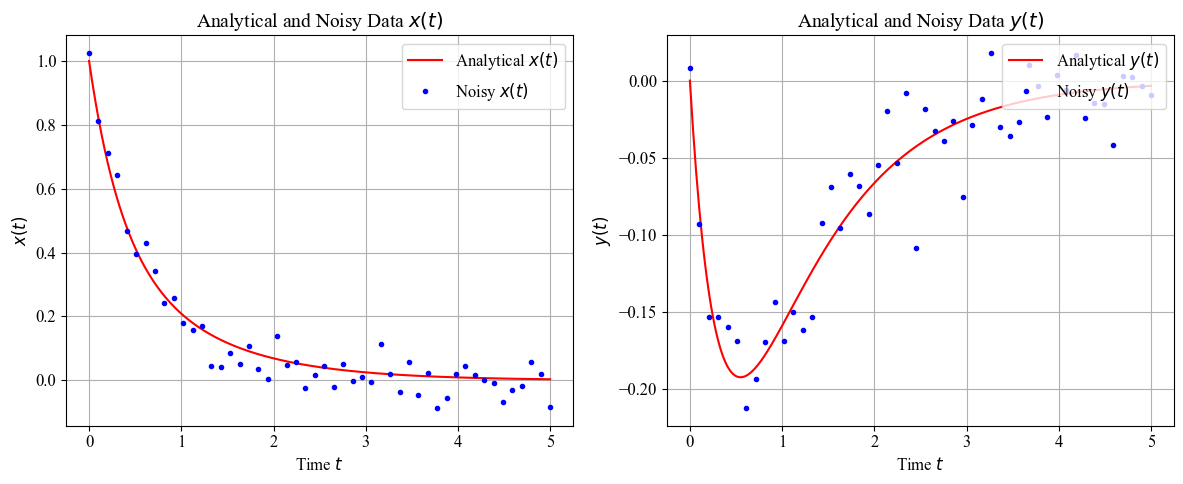

In [9]:
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_test, x_true, label=r'Analytical $x(t)$', color='red')
plt.plot(t_noisy, x_noisy, 'b.', label=r'Noisy $x(t)$')
plt.title(r'Analytical and Noisy Data $x(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.subplot(1,2,2)
plt.plot(t_test, y_true, label=r'Analytical $y(t)$', color='red')
plt.plot(t_noisy, y_noisy, 'b.', label=r'Noisy $y(t)$')
plt.title(r'Analytical and Noisy Data $y(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$y(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.tight_layout()
plt.show()

### Create the Data loss function

In [10]:
def loss_data(data, pred):
    """
    Data Loss Function: Computes the mean squared error (MSE)
    between data and predictions across all dimensions.
    
    Parameters:
    - data (torch.Tensor): Ground truth values.
    - pred (torch.Tensor): Predicted values.

    Returns:
    - torch.Tensor: The computed MSE loss.
    """
    # Compute mean squared error across all dimensions
    loss_data = torch.mean((data - pred) ** 2)
    return loss_data

## Compare data loss with analytical solution
The data loss for the generated data as compared to the analytical data is:

In [11]:
def to_tensor(array, dtype=torch.float32):
    """
    Converts input to a PyTorch tensor if it's not already a tensor.
    """
    if isinstance(array, torch.Tensor):
        return array
    return torch.tensor(array, dtype=dtype)

# Convert numpy arrays to PyTorch tensors, if necessary
x_noisy_tensor = to_tensor(x_noisy)
y_noisy_tensor = to_tensor(y_noisy)

# Compute the noisy solution
x_noisy_sol, y_noisy_sol = solution(t_noisy)
x_noisy_sol_tensor = to_tensor(x_noisy_sol)
y_noisy_sol_tensor = to_tensor(y_noisy_sol)

# Stack tensors along the last dimension
data_noise = torch.stack([x_noisy_tensor, y_noisy_tensor], dim=-1)
sol_noise= torch.stack([x_noisy_sol_tensor, y_noisy_sol_tensor], dim=-1)

# Compute the loss
print(f"Data loss wrt analytical soln: {loss_data(data_noise, sol_noise).item():.8f}")

# Test the model
t_noisy_tensor = torch.tensor(t_noisy.reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    predictions = model(t_noisy_tensor)
    x_noisy_pred, y_noisy_pred = predictions[:, 0].numpy(), predictions[:, 1].numpy()
pred_noisy = torch.stack([to_tensor(x_noisy_pred), to_tensor(y_noisy_pred)], dim=-1)
print(f"Data loss wrt predicted NN soln: {loss_data(data_noise, pred_noisy).item():.8f}")



Data loss wrt analytical soln: 0.00136564
Data loss wrt predicted NN soln: 0.00136945


# Now retrain the PINN on the provided data

This time I will include the data as the source of information and the data loss as another term.

## New Set up
1. Define a new total loss function (TLF)
2. Define a new train funciton that uses the new TLF.

In [12]:
def loss_fn(model, t, data):
    """ Total Loss Function """
    # Enable gradient tracking
    t.requires_grad_(True)

    # Forward pass
    output = model(t)
    x = output[:, 0:1]
    y = output[:, 1:2]

    # Compute gradients dx/dt and dy/dt
    dxdt = torch.autograd.grad(outputs=x, inputs=t,
                                grad_outputs=torch.ones_like(x),
                                create_graph=True)[0]
    dydt = torch.autograd.grad(outputs=y, inputs=t,
                                grad_outputs=torch.ones_like(y),
                                create_graph=True)[0]

    # Residual ODEs
    res_x = dxdt + 2 * x + y
    res_y = dydt + x + 2 * y
    loss_residuals = torch.mean(res_x ** 2) + torch.mean(res_y ** 2)

    # Initial Conditions (IC) Loss
    ICx = (x[0] - 1) ** 2
    ICy = (y[0] - 0) ** 2
    loss_IC = ICx + ICy

    # Data loss    
    pred = torch.stack([to_tensor(x), to_tensor(y)], dim=-1)
    data_loss = loss_data(data, pred)

    # Total loss
    loss = loss_residuals + loss_IC + data_loss

    return loss

def train(model, t, epochs, optimizer, data):
    for epoch in range(epochs):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the loss
        loss = loss_fn(model, t, data)
        
        # Backpropagation
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Print loss periodically
        if epoch % 500 == 0:
            print(f"Epoch {epoch} Loss: {loss.item()}")



## Run the model

In [13]:
# Run our model
model = PINN()

# Define the optimizer
# optimizer = tf.keras.optimizer.Adam(learning_rate=0.001) # control rate
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Control rate

# Define domain (t ∈ [0, 5]) -- "Collection Points"
# t = tf.convert_to_tensor(np.linspace(0,5,100)[:, None], dtype=tf.float32)
# t = torch.tensor(np.linspace(0, 5, 100).reshape(-1, 1), dtype=torch.float32)
t = t_noisy_tensor

# Train the model
train(model, t, epochs=4000, optimizer=optimizer, data=data_noise)

# Test the model
t_test = torch.tensor(np.linspace(0, 5, 100).reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    predictions = model(t_test)
    x_pred, y_pred = predictions[:, 0].numpy(), predictions[:, 1].numpy()

Epoch 0 Loss: 2.5069921016693115
Epoch 500 Loss: 0.057240989059209824
Epoch 1000 Loss: 0.05413961410522461
Epoch 1500 Loss: 0.054013896733522415
Epoch 2000 Loss: 0.053990866988897324
Epoch 2500 Loss: 0.05422347038984299
Epoch 3000 Loss: 0.05397947505116463
Epoch 3500 Loss: 0.053976889699697495


## Visualize

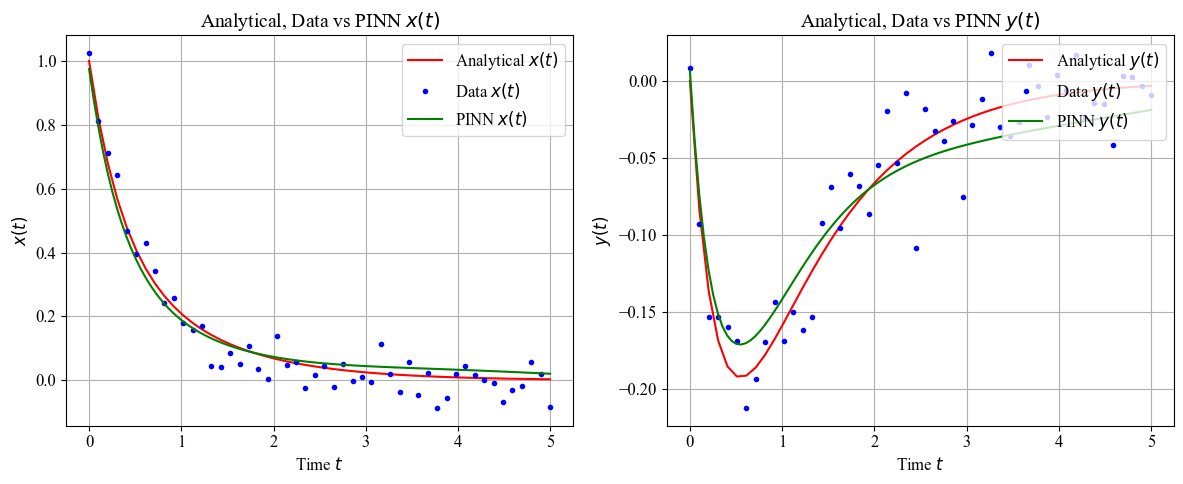

In [14]:
# Compare results:
x_true, y_true = solution(t_noisy)

plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_noisy, x_true, label=r'Analytical $x(t)$', color='red')
plt.plot(t_noisy, x_noisy, 'b.', label=r'Data $x(t)$')
plt.plot(t_test, x_pred, 'g-', label=r"PINN $x(t)$")
plt.title(r'Analytical, Data vs PINN $x(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.subplot(1,2,2)
plt.plot(t_noisy, y_true, label=r'Analytical $y(t)$', color='red')
plt.plot(t_noisy, y_noisy, 'b.', label=r'Data $y(t)$')
plt.plot(t_test, y_pred, 'g-', label=r"PINN $y(t)$")
plt.title(r'Analytical, Data vs PINN $y(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$y(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.tight_layout()
plt.show()

## Now increase the epochs
The purpose here is to see if we can get better fits by increasing the number of training epochs.  As will be shown below in the results, it is possible to run through and past the best solution (at least visually).

In [15]:
# Run our model
model = PINN()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Control rate

# Train the model
train(model, t, epochs=50000, optimizer=optimizer, data=data_noise)

# Test the model
t_test = torch.tensor(np.linspace(0, 5, 100).reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    predictions = model(t_test)
    x_pred, y_pred = predictions[:, 0].numpy(), predictions[:, 1].numpy()

Epoch 0 Loss: 1.8538792133331299
Epoch 500 Loss: 0.05448096618056297
Epoch 1000 Loss: 0.054056040942668915
Epoch 1500 Loss: 0.054018259048461914
Epoch 2000 Loss: 0.053999871015548706
Epoch 2500 Loss: 0.05399220064282417
Epoch 3000 Loss: 0.05398789048194885
Epoch 3500 Loss: 0.053984902799129486
Epoch 4000 Loss: 0.053981930017471313
Epoch 4500 Loss: 0.05447401478886604
Epoch 5000 Loss: 0.05397612601518631
Epoch 5500 Loss: 0.05400565639138222
Epoch 6000 Loss: 0.05414272099733353
Epoch 6500 Loss: 0.05396709218621254
Epoch 7000 Loss: 0.05396420136094093
Epoch 7500 Loss: 0.05396175757050514
Epoch 8000 Loss: 0.05396311357617378
Epoch 8500 Loss: 0.05395510047674179
Epoch 9000 Loss: 0.05395033210515976
Epoch 9500 Loss: 0.05394240468740463
Epoch 10000 Loss: 0.05392734333872795
Epoch 10500 Loss: 0.05393264442682266
Epoch 11000 Loss: 0.054618507623672485
Epoch 11500 Loss: 0.04432843625545502
Epoch 12000 Loss: 0.04273111745715141
Epoch 12500 Loss: 0.042585816234350204
Epoch 13000 Loss: 0.0425717160

## Visualize

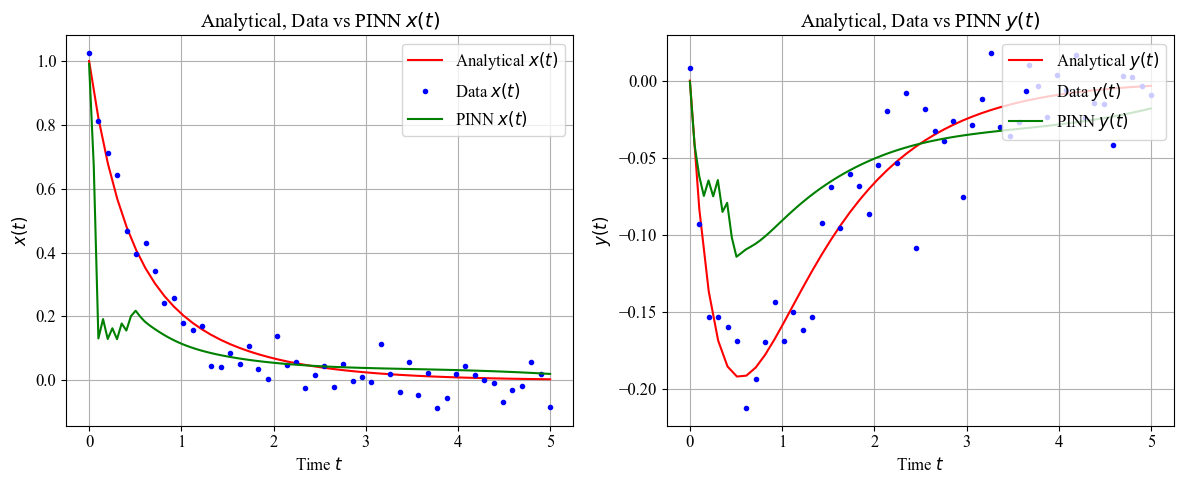

In [16]:
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_noisy, x_true, label=r'Analytical $x(t)$', color='red')
plt.plot(t_noisy, x_noisy, 'b.', label=r'Data $x(t)$')
plt.plot(t_test, x_pred, 'g-', label=r"PINN $x(t)$")
plt.title(r'Analytical, Data vs PINN $x(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.subplot(1,2,2)
plt.plot(t_noisy, y_true, label=r'Analytical $y(t)$', color='red')
plt.plot(t_noisy, y_noisy, 'b.', label=r'Data $y(t)$')
plt.plot(t_test, y_pred, 'g-', label=r"PINN $y(t)$")
plt.title(r'Analytical, Data vs PINN $y(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$y(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.tight_layout()
plt.show()

This is an interesting finding when I increased the number of epochs significantly.  It seems like the data in my example is highly populuated towards the higher numbers and causes the model to find solutions that are more favorable for that domain and allows a poor fit for the lesser number of data points on the lower domain values.

In a real problem, we will normalize the data with zero mean and unit variance which should help in this problem.  But in real life, we may have skewed data that is more populated unequally for different regions of the observation domain.

Regardless, I think this example serves as a reasonable starting point for applying the PINN method to fit data that is governed by physical laws of nature.

# Refactor the code and re-run
To optimize and streamline the given PINN implementation, here's an enhanced version utilizing more PyTorch features.

**Key Enhancements and Changes Made**:
- Integrated PINN Class with Proper Structure: The model is now a single class with clear layers, including input, hidden, and output layers.
- Simplified Loss Function: Utilizes PyTorch's built-in nn.MSELoss() for data loss computation and automates gradient calculation using torch.autograd.grad, which is more efficient than manual computation.
- Efficient ODE Handling: Residuals are computed directly without manually separating the terms, leveraging the computed gradients.
- Data Loading with DataLoader: Uses PyTorch's DataLoader to handle batches, improving memory efficiency and training speed.
- Regularization Techniques: Added dropout in the hidden layers for better regularization.
- Model Testing in a Clean Manner: The test method returns predictions without gradient computation to avoid unnecessary computations.
- Improved Code Structure with Classes: Separates concerns into a PINNTrainer class, making code more modular and easier to maintain.
- Documentation and Readability: Added comments and structured the code for clarity, making it easier to understand and modify.
- Error Handling: Uses proper tensor operations and ensures that data is on the correct device (e.g., GPU if applicable).
- Optimization of Initial Conditions: Fixed initial conditions are used but can be modified based on specific problem requirements.

**Implementation Insights:**
- The enhanced code uses PyTorch's optimized functions for gradient computation, leading to better performance.
- DataLoader helps in efficient batch processing, which is crucial for large datasets.
Regularization layers like dropout help prevent overfitting by reducing connectivity during training.
- The PINN structure allows the model to learn the underlying dynamics of ODEs while respecting initial conditions and residual equations.
- This implementation provides a cleaner, more efficient, and maintainable approach to solving ODEs using PINNs in PyTorch.

In [17]:
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from pinn_models import PINN, PINNDataset, PINNTrainer, to_tensor

def print_stats(x_pred, y_pred, x_test_sol, y_test_sol):
        # Statistics
        f1_score_y, accuracy_score_y, roc_auc_score_y = (
            f1_score(y_test_sol, y_pred),
            accuracy_score(y_test_sol, y_pred),
            roc_auc_score(y_test_sol, y_pred))
        f1_score_x, accuracy_score_x, roc_auc_score_x = (
            f1_score(x_test_sol, x_pred),
            accuracy_score(x_test_sol, x_pred),
            roc_auc_score(x_test_sol, x_pred))
        f1_tot = np.mean(f1_score_x, f1_score_y)
        acc_tot = np.mean(accuracy_score_x, accuracy_score_y)
        rocauc_tot = np.mean(roc_auc_score_x, roc_auc_score_y)
        print("Test predictions (x):")
        print(f"     F1:        {f1_score_x:.5f}")
        print(f"     Accuracy:  {accuracy_score_x:.5f}")
        print(f"     ROC AUC:   {roc_auc_score_x:.5f}")
        print("Test predictions (y):")
        print(f"     F1:        {f1_score_y:.5f}")
        print(f"     Accuracy:  {accuracy_score_y:.5f}")
        print(f"     ROC AUC:   {roc_auc_score_y:.5f}")
        print("Test predictions (total):")
        print(f"     F1:        {f1_tot:.5f}")
        print(f"     Accuracy:  {acc_tot:.5f}")
        print(f"     ROC AUC:   {rocauc_tot:.5f}")
        
# Example usage:
def main(batch_size: int = 50, num_workers: int = 0):
    # Define training dataset
    noisy_data = np.array([t_noisy, x_noisy, y_noisy]).T
    print(f"Dimensions of noisy_data: {noisy_data.shape}")
    X_train, X_test, train_t, test_t = train_test_split(
        noisy_data[:,:2], noisy_data[:,2], test_size=0.25, random_state=42)
    train_x = X_train[:,0]
    train_y = X_train[:,1]

    # print(f"Dimensions of x_noisy: {x_noisy.shape}")
    # print(f"Dimensions of y_noisy: {y_noisy.shape}")
    # print(f"Dimensions of X_train: {X_train.shape}")
    # print(f"Dimensions of train_x: {train_x.shape}")
    # print(f"Dimensions of X_test: {X_test.shape}")

    train_dataset = PINNDataset(train_t, train_x, train_y)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers  # Adjust based on available CPUs/GPUs
    )

    # Define test dataset (if needed)
    test_x = X_test[0,:]
    test_y = X_test[1,:]

    test_dataset = PINNDataset(test_t, test_x, test_y)
    test_loader = DataLoader(
        test_dataset,
        batch_size=100,
        shuffle=False,
        num_workers=num_workers
    )

    # Initialize model and optimizer
    model = PINN(hidden_size=64, output_size=2).to(torch.float32)
    optimizer = Adam(model.parameters(), lr=0.001)

    # Training
    trainer = PINNTrainer(model, optimizer, train_loader, test_loader)
    trainer.train()

    # Testing
    x_pred, y_pred, x_test_sol, y_test_sol = trainer.test()
    # print(f"Test predictions: x={x_pred}, y={y_pred}")
    
    print_stats(x_pred, y_pred, x_test_sol, y_test_sol)

# if __name__ == "__main__":
#     main()


In [18]:
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from pinn_models import PINN, PINNDataset, PINNTrainer

# In your main function or where you define data
num_workers = 0
batch_size= 50
# Define training dataset
noisy_data = np.array([t_noisy, x_noisy, y_noisy]).T
print(f"Dimensions of noisy_data: {noisy_data.shape}")
X_train, X_test, train_t, test_t = train_test_split(
    noisy_data[:,:2], noisy_data[:,2], test_size=0.25, random_state=42)
train_x = X_train[:,0]
train_y = X_train[:,1]

train_t = train_t.reshape(-1, 1)  # Ensure train_t has shape (batch_size, 1)
test_t = test_t.reshape(-1, 1)    # Ensure test_t has shape (batch_size, 1)

# print(f"Dimensions of x_noisy: {x_noisy.shape}")
# print(f"Dimensions of y_noisy: {y_noisy.shape}")
# print(f"Dimensions of X_train: {X_train.shape}")
# print(f"Dimensions of train_x: {train_x.shape}")
# print(f"Dimensions of X_test: {X_test.shape}")

train_dataset = PINNDataset(train_t, train_x, train_y)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers  # Adjust based on available CPUs/GPUs
)

# Define test dataset (if needed)
test_x = X_test[:,0]
test_y = X_test[:,1]

test_dataset = PINNDataset(test_t, test_x, test_y)
test_loader = DataLoader(
    test_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=num_workers
)

# Initialize model and optimizer
model = PINN(hidden_size=64, output_size=2).to(torch.float32)
optimizer = Adam(model.parameters(), lr=0.001)

# Training
trainer = PINNTrainer(model, optimizer, train_loader, test_loader)
trainer.train()

# Testing
predictions = trainer.test()
x_preds, y_preds, x_tests, y_tests = zip(*predictions)  # Unzip list of tuples

# Convert lists to numpy arrays
x_pred = np.concatenate(x_preds, axis=0)
y_pred = np.concatenate(y_preds, axis=0)
x_test_sol = np.concatenate(x_tests, axis=0)
y_test_sol = np.concatenate(y_tests, axis=0)



Dimensions of noisy_data: (50, 3)
Epoch 0 Loss: 9.309698
Epoch 500 Loss: 4.394049
Epoch 1000 Loss: 4.424132
Epoch 1500 Loss: 4.530359
Epoch 2000 Loss: 4.567619
Epoch 2500 Loss: 4.256305
Epoch 3000 Loss: 4.363825
Epoch 3500 Loss: 4.173577


In [19]:
# Now x_pred, y_pred, x_test_sol, y_test_sol contain all test samples
x_pred_bin = (x_pred > 0.5).astype(int)
y_pred_bin = (y_pred > 0.5).astype(int)
x_test_sol_bin = (x_test_sol > 0.5).astype(int)
y_test_sol_bin = (y_test_sol > 0.5).astype(int)
# print_stats(x_pred_bin, y_pred_bin, x_test_sol_bin, y_test_sol_bin)





### Continuous results comparisons
Because the results are continuous, lets' change the way we compare the results.

1. Mean Squared Error (MSE)

Measures the average squared difference between predictions and the true values. This is a common metric for regression tasks.


MSE = \frac{1}{N} \sum (x_{\text{pred}} - x_{\text{true}})^2

2. Mean Absolute Error (MAE)

Measures the average absolute difference between predictions and the true values.


MAE = \frac{1}{N} \sum |x_{\text{pred}} - x_{\text{true}}|

3. R-Squared (R²) Score

Measures how well predictions approximate the actual values. A value close to 1.0 indicates a strong correlation.


R^2 = 1 - \frac{\sum (x_{\text{true}} - x_{\text{pred}})^2}{\sum (x_{\text{true}} - \bar{x}_{\text{true}})^2}

4. Pearson Correlation Coefficient

Measures the linear correlation between the predicted and actual values. Values close to 1.0 indicate a strong positive correlation.


r = \frac{\sum (x_{\text{true}} - \bar{x}{\text{true}}) (x{\text{pred}} - \bar{x}{\text{pred}})}
{\sqrt{\sum (x{\text{true}} - \bar{x}{\text{true}})^2 \sum (x{\text{pred}} - \bar{x}_{\text{pred}})^2}}

5. Cosine Similarity

Measures how similar the predicted and actual vectors are in terms of direction, ranging from -1 (opposite) to 1 (identical).


\cos(\theta) = \frac{x_{\text{pred}} \cdot x_{\text{true}}}{||x_{\text{pred}}|| \cdot ||x_{\text{true}}||}

6. Normalized Root Mean Squared Error (NRMSE)

Divides RMSE by the range or mean of true values for better interpretability.


NRMSE = \frac{\sqrt{MSE}}{\max(x_{\text{true}}) - \min(x_{\text{true}})}

### Which Metric Should You Use?
	•	For overall performance: MSE, MAE, RMSE
	•	For correlation: Pearson correlation or R² score
	•	For similarity of shape: Cosine similarity
	•	For normalized comparison: Normalized RMSE

In [20]:
def print_stats_continuous(x_pred, y_pred, x_test_sol, y_test_sol):
    from sklearn.metrics import mean_squared_error

    mse_x = mean_squared_error(x_test_sol, x_pred)
    mse_y = mean_squared_error(y_test_sol, y_pred)

    print(f"Mean Squared Error (X): {mse_x:.5f}")
    print(f"Mean Squared Error (Y): {mse_y:.5f}")

    from sklearn.metrics import mean_absolute_error

    mae_x = mean_absolute_error(x_test_sol, x_pred)
    mae_y = mean_absolute_error(y_test_sol, y_pred)

    print(f"Mean Absolute Error (X): {mae_x:.5f}")
    print(f"Mean Absolute Error (Y): {mae_y:.5f}")

    from sklearn.metrics import r2_score

    r2_x = r2_score(x_test_sol, x_pred)
    r2_y = r2_score(y_test_sol, y_pred)

    print(f"R-squared Score (X): {r2_x:.5f}")
    print(f"R-squared Score (Y): {r2_y:.5f}")

    import scipy.stats

    corr_x, _ = scipy.stats.pearsonr(x_test_sol.flatten(), x_pred.flatten())
    corr_y, _ = scipy.stats.pearsonr(y_test_sol.flatten(), y_pred.flatten())

    print(f"Pearson Correlation (X): {corr_x:.5f}")
    print(f"Pearson Correlation (Y): {corr_y:.5f}")

    from sklearn.metrics.pairwise import cosine_similarity

    cosine_x = cosine_similarity(x_test_sol.reshape(1, -1), x_pred.reshape(1, -1))[0][0]
    cosine_y = cosine_similarity(y_test_sol.reshape(1, -1), y_pred.reshape(1, -1))[0][0]

    print(f"Cosine Similarity (X): {cosine_x:.5f}")
    print(f"Cosine Similarity (Y): {cosine_y:.5f}")

    rmse_x = np.sqrt(mean_squared_error(x_test_sol, x_pred)) / (np.max(x_test_sol) - np.min(x_test_sol))
    rmse_y = np.sqrt(mean_squared_error(y_test_sol, y_pred)) / (np.max(y_test_sol) - np.min(y_test_sol))

    print(f"Normalized RMSE (X): {rmse_x:.5f}")
    print(f"Normalized RMSE (Y): {rmse_y:.5f}")

    # Visualization
    plt.figure(figsize=(12, 8))

    # Plot X predictions vs. True values
    plt.subplot(2, 2, 1)
    plt.plot(x_test_sol, x_test_sol, 'g--', label="True x")
    plt.scatter(x_test_sol, x_pred, color='b', alpha=0.5, label="Predicted x")
    plt.title(f'X Predictions (MSE: {mse_x:.4f}, R2: {r2_x:.4f}, Corr: {corr_x:.4f})')
    plt.xlabel('True x')
    plt.ylabel('Predicted x')
    plt.legend()

    # Plot Y predictions vs. True values
    plt.subplot(2, 2, 2)
    plt.plot(y_test_sol, y_test_sol, 'g--', label="True y")
    plt.scatter(y_test_sol, y_pred, color='r', alpha=0.5, label="Predicted y")
    plt.title(f'Y Predictions (MSE: {mse_y:.4f}, R2: {r2_y:.4f}, Corr: {corr_y:.4f})')
    plt.xlabel('True y')
    plt.ylabel('Predicted y')
    plt.legend()

    # Error distributions
    plt.subplot(2, 2, 3)
    bin_edges = np.histogram_bin_edges((x_pred - x_test_sol).flatten(), bins=20)
    plt.hist((x_pred - x_test_sol).flatten(), bins=bin_edges, alpha=0.7, label="X Error", color='b', align='left', rwidth=0.4)
    plt.hist((y_pred - y_test_sol).flatten(), bins=bin_edges, alpha=0.7, label="Y Error", color='r', align='right', rwidth=0.4)
    # plt.hist((x_pred - x_test_sol).flatten(), bins=20, alpha=0.7, label="X Error", color='b')
    # plt.hist((y_pred - y_test_sol).flatten(), bins=20, alpha=0.7, label="Y Error", color='r')
    # plt.hist(x_pred - x_test_sol, bins=20, alpha=0.7, label="X Error", color='b')
    # plt.hist(y_pred - y_test_sol, bins=20, alpha=0.7, label="Y Error", color='r')
    plt.title("Error Distribution")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.legend()

    # Scatter plot of predictions vs true values
    plt.subplot(2, 2, 4)
    plt.scatter(x_test_sol, x_pred, alpha=0.5, label="X Prediction", color='b')
    plt.scatter(y_test_sol, y_pred, alpha=0.5, label="Y Prediction", color='r')
    plt.plot([-1, 2], [-1, 2], 'k--', label="Perfect Fit")
    plt.title("Predictions vs. Ground Truth")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()

    plt.tight_layout()
    plt.show()

Mean Squared Error (X): 0.00000
Mean Squared Error (Y): 0.00000
Mean Absolute Error (X): 0.00000
Mean Absolute Error (Y): 0.00000
R-squared Score (X): 1.00000
R-squared Score (Y): 1.00000
Pearson Correlation (X): nan
Pearson Correlation (Y): nan
Cosine Similarity (X): 1.00000
Cosine Similarity (Y): 0.00000
Normalized RMSE (X): nan
Normalized RMSE (Y): nan


/var/folders/bj/ncr1n7_13gv1_cr07lsbnl7h0000gn/T/ipykernel_5702/2410582433.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_x, _ = scipy.stats.pearsonr(x_test_sol.flatten(), x_pred.flatten())
/var/folders/bj/ncr1n7_13gv1_cr07lsbnl7h0000gn/T/ipykernel_5702/2410582433.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_y, _ = scipy.stats.pearsonr(y_test_sol.flatten(), y_pred.flatten())
/var/folders/bj/ncr1n7_13gv1_cr07lsbnl7h0000gn/T/ipykernel_5702/2410582433.py:42: RuntimeWarning: invalid value encountered in scalar divide
  rmse_x = np.sqrt(mean_squared_error(x_test_sol, x_pred)) / (np.max(x_test_sol) - np.min(x_test_sol))
/var/folders/bj/ncr1n7_13gv1_cr07lsbnl7h0000gn/T/ipykernel_5702/2410582433.py:43: RuntimeWarning: invalid value encountered in scalar divide
  rmse_y = np.sqrt(mean_squared_error(y_test_sol, y_pred)) / (np.max(y_test_sol) - np.min(y_test_sol))


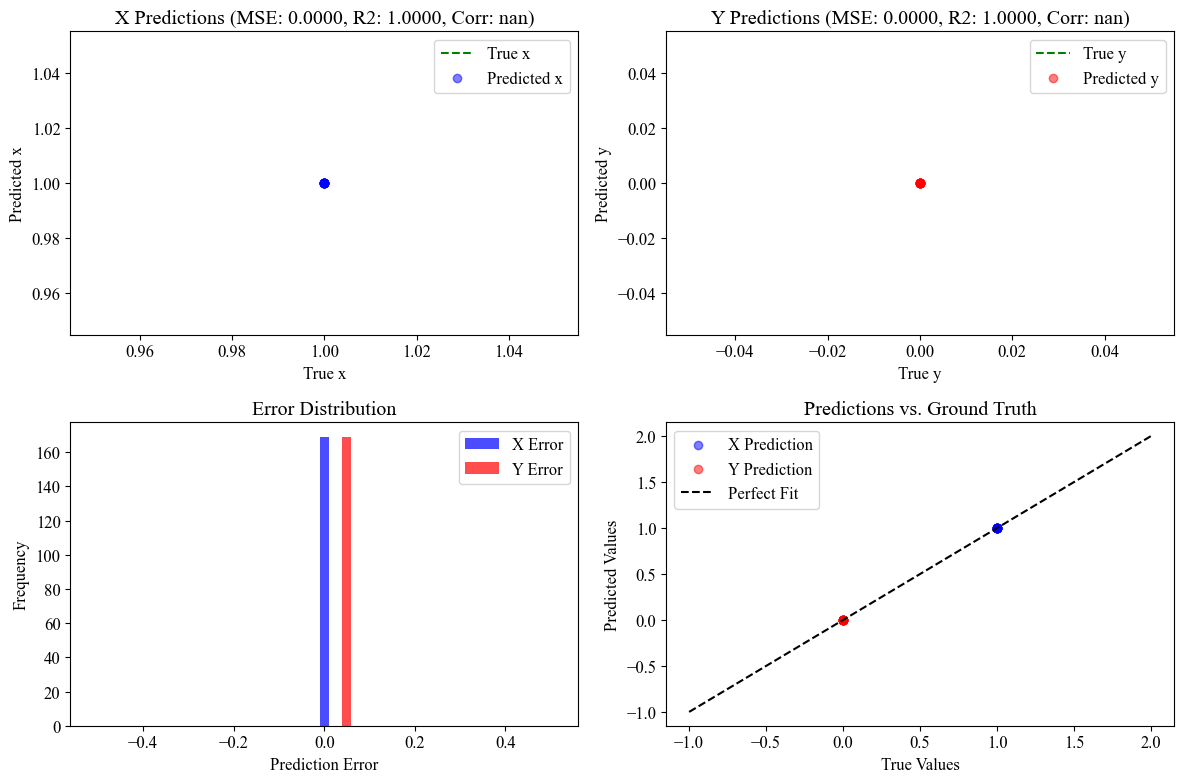

In [21]:
print_stats_continuous(x_pred_bin, y_pred_bin, x_test_sol_bin, y_test_sol_bin)

# Now let's predict last data point

### Observations from the pinn_models.py file:
1.	PINNDataset:
- Handles t, x, y values and converts them into tensors.
- Can be modified to exclude data where ￼.
2.	PINN Model:
- Has one hidden layer with dropout (0.2).
- Uses ReLU activation.
- Can be modified to keep dropout active during inference for Monte Carlo (MC) Dropout.
3.	PINNTrainer:
- Trains the model and tests it.
- Can be modified to make multiple forward passes (MC Dropout) during inference.

### Modifications Needed
1. Modify PINNDataset to exclude data where $t > \text{threshold}$ ::

``` python
class PINNDataset(Dataset):
    def __init__(self, t, x, y, threshold=None):
        # Convert inputs to numpy arrays (ensure they are 1D)
        t, x, y = np.asarray(t).flatten(), np.asarray(x).flatten(), np.asarray(y).flatten()

        # Create mask (ensure it's the same shape as t)
        mask = (t <= threshold) if threshold is not None else np.ones_like(t, dtype=bool)

        # Apply the mask correctly
        self.t = to_tensor(t[mask])
        self.x = to_tensor(x[mask])
        self.y = to_tensor(y[mask])
```
- Filters out values above the threshold.

2. Modify PINN to Enable MC Dropout:

``` python
class PINN(nn.Module):
    def __init__(self, hidden_size=64, output_size=2):
        super(PINN, self).__init__()
        self.in_layer = nn.Linear(1, hidden_size)
        self.h1 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2)  # Dropout enabled
        )
        self.out_layer = nn.Linear(hidden_size, output_size)

    def forward(self, t):
        x = torch.sin(t)  # Assuming t is in radians
        x = self.in_layer(x)
        x = self.h1(x)
        pred = self.out_layer(x)
        return pred

    def enable_dropout(self):
        """Enables dropout during inference for Monte Carlo estimation"""
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.train()
```
- enable_dropout() allows dropout to remain active during testing.

3. Modify PINNTrainer to Perform MC Dropout Predictions:

``` python
def predict_with_uncertainty(self, t_test, num_samples=100):
    """Performs MC Dropout by making multiple forward passes"""
    self.model.enable_dropout()  # Enable dropout during inference

    preds = torch.stack([self.model(t_test) for _ in range(num_samples)])
    mean_pred = preds.mean(dim=0)
    std_pred = preds.std(dim=0)  # Standard deviation for uncertainty

    return mean_pred, std_pred
```
- Runs 100 forward passes and computes mean and standard deviation.

### Final Steps in Your Script

Modify the dataset and testing process:
``` python
# Set threshold
threshold = 5.0  # Adjust based on your needs

# Modify dataset to exclude data above threshold
train_dataset = PINNDataset(train_t, train_x, train_y, threshold=threshold)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = PINN(hidden_size=64, output_size=2).to(torch.float32)
optimizer = Adam(model.parameters(), lr=0.001)

# Train model
trainer = PINNTrainer(model, optimizer, train_loader, test_loader)
trainer.train()

# Predict missing data points with uncertainty
t_future = torch.tensor(np.linspace(threshold, max(t_noisy), 50).reshape(-1, 1), dtype=torch.float32)
mean_pred, std_pred = trainer.predict_with_uncertainty(t_future, num_samples=100)

# Convert to numpy for analysis
mean_pred_np = mean_pred.detach().numpy()
std_pred_np = std_pred.detach().numpy()

# Print the final predicted value with 80% confidence interval
lower_bound = mean_pred_np - 1.28 * std_pred_np
upper_bound = mean_pred_np + 1.28 * std_pred_np

print("Final Prediction at max t:", mean_pred_np[-1])
print("80% Confidence Interval:", (lower_bound[-1], upper_bound[-1]))
```
### Summary of Changes
- Filter training data to exclude values where ￼.
- Enable Monte Carlo Dropout for uncertainty estimation.
- Predict missing values with confidence intervals.


In [22]:
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from pinn_model_lastpt import PINN, PINNDataset, PINNTrainer

# Set threshold
threshold = 5.0  # Adjust based on your needs

# Modify dataset to exclude data above threshold
train_dataset = PINNDataset(train_t, train_x, train_y, threshold=threshold)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = PINN(hidden_size=64, output_size=2).to(torch.float32)
optimizer = Adam(model.parameters(), lr=0.001)

# Train model
trainer = PINNTrainer(model, optimizer, train_loader, test_loader)
trainer.train()

# Predict missing data points with uncertainty
t_future = torch.tensor(np.linspace(threshold, max(t_noisy), 50).reshape(-1, 1), dtype=torch.float32)
mean_pred, std_pred = trainer.predict_with_uncertainty(t_future, num_samples=100)

# Convert to numpy for analysis
mean_pred_np = mean_pred.detach().numpy()
std_pred_np = std_pred.detach().numpy()

# Print the final predicted value with 80% confidence interval
lower_bound = mean_pred_np - 1.28 * std_pred_np
upper_bound = mean_pred_np + 1.28 * std_pred_np

print("Final Prediction at max t:", mean_pred_np[-1])
print("80% Confidence Interval:", (lower_bound[-1], upper_bound[-1]))

Epoch 0 Loss: 9.256567
Epoch 500 Loss: 4.961732
Epoch 1000 Loss: 4.838302
Epoch 1500 Loss: 4.637619
Epoch 2000 Loss: 6.991232
Epoch 2500 Loss: 6.324561
Epoch 3000 Loss: 6.373124
Epoch 3500 Loss: 6.520447
Final Prediction at max t: [4.9949574 2.0437324]
80% Confidence Interval: (array([4.335801 , 1.6754953], dtype=float32), array([5.654114 , 2.4119697], dtype=float32))


In [23]:
def plot_comparison_lastpt(pred_pt, lower_bound, upper_bound, true_pt):
    # Computed data point
    x_computed, y_computed = np.array(pred_pt) # 5, 10
    x_lower, x_upper = np.array(lower_bound) # 4, 6  # Lower and upper bounds for x
    y_lower, y_upper = np.array(upper_bound) # 8, 12  # Lower and upper bounds for y

    # True data point
    x_true, y_true = np.array(true_pt) # 5.5, 9.5

    # Compute error margins ensuring positive values
    x_err = [[abs(x_computed - x_lower)], [abs(x_upper - x_computed)]]  # Asymmetrical error
    y_err = [[abs(y_computed - y_lower)], [abs(y_upper - y_computed)]]

    # Plot computed data with error bars
    plt.errorbar(x_computed, y_computed, xerr=x_err, yerr=y_err, fmt='o', color='blue', label='Computed Data (w/ bounds)', capsize=5)

    # Plot true data point
    plt.scatter(x_true, y_true, color='red', marker='s', s=100, label='True Data Point')

    # Labels and legend
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Comparison of Computed vs. True Data Point")
    plt.legend()
    plt.grid(True)
    plt.show()

    import matplotlib.patches as patches
    fig, ax = plt.subplots()

    # Plot the computed data point
    plt.scatter(x_computed, y_computed, color='blue', label='Computed Data', zorder=2)

    # Plot the true data point
    plt.scatter(x_true, y_true, color='red', marker='s', s=100, label='True Data Point', zorder=3)

    # Create a rectangle for the uncertainty bounds
    ellipse = patches.Ellipse(
        (x_computed, y_computed), # xy coordinates of ellipse centre
        x_upper - x_lower, # Total length (diameter) of horizontal axis
        y_upper - y_lower, # Total length (diameter) of vertical axis
        angle=0, # Rotation in degrees anti-clockwise
        linewidth=1, edgecolor='blue', facecolor='lightblue', 
        alpha=0.3, label='Uncertainty Region')

    # Add the rectangle to the plot
    ax.add_patch(ellipse)

    # Labels and legend
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Computed vs. True Data with Uncertainty Region")
    plt.legend()
    plt.grid(True)
    plt.show()

def print_stats_lastpt(x_pred, y_pred, x_test_sol, y_test_sol):
    # True and Predicted values of endpoints:
    print("True and Predicted values of endpoints")
    # print(f"True (x, y) = ({x_test_sol:.2f}, {y_test_sol:.2f})")
    # print(f"Pred (x, y) = ({x_pred:.2f}, {y_pred:.2f})")
    print(f"True (x, y) final = ({x_test_sol[-1]}, {y_test_sol[-1]})")
    print(f"Pred (x, y) final = ({x_pred[-1]}, {y_pred[-1]})")

    # Ensure equal length for all inputs
    min_samples = min(len(x_pred), len(x_test_sol))
    x_pred, y_pred = x_pred[:min_samples], y_pred[:min_samples]
    x_test_sol, y_test_sol = x_test_sol[:min_samples], y_test_sol[:min_samples]

    from sklearn.metrics import mean_squared_error
    mse_x = mean_squared_error(x_test_sol, x_pred)
    mse_y = mean_squared_error(y_test_sol, y_pred)

    print(f"Mean Squared Error (X): {mse_x:.5f}")
    print(f"Mean Squared Error (Y): {mse_y:.5f}")

    from sklearn.metrics import mean_absolute_error

    mae_x = mean_absolute_error(x_test_sol, x_pred)
    mae_y = mean_absolute_error(y_test_sol, y_pred)

    print(f"Mean Absolute Error (X): {mae_x:.5f}")
    print(f"Mean Absolute Error (Y): {mae_y:.5f}")

    from sklearn.metrics import r2_score

    r2_x = r2_score(x_test_sol, x_pred)
    r2_y = r2_score(y_test_sol, y_pred)

    print(f"R-squared Score (X): {r2_x:.5f}")
    print(f"R-squared Score (Y): {r2_y:.5f}")

    import scipy.stats

    corr_x, _ = scipy.stats.pearsonr(x_test_sol.flatten(), x_pred.flatten())
    corr_y, _ = scipy.stats.pearsonr(y_test_sol.flatten(), y_pred.flatten())

    print(f"Pearson Correlation (X): {corr_x:.5f}")
    print(f"Pearson Correlation (Y): {corr_y:.5f}")

    from sklearn.metrics.pairwise import cosine_similarity

    cosine_x = cosine_similarity(x_test_sol.reshape(1, -1), x_pred.reshape(1, -1))[0][0]
    cosine_y = cosine_similarity(y_test_sol.reshape(1, -1), y_pred.reshape(1, -1))[0][0]

    print(f"Cosine Similarity (X): {cosine_x:.5f}")
    print(f"Cosine Similarity (Y): {cosine_y:.5f}")

    rmse_x = np.sqrt(mean_squared_error(x_test_sol, x_pred)) / (np.max(x_test_sol) - np.min(x_test_sol))
    rmse_y = np.sqrt(mean_squared_error(y_test_sol, y_pred)) / (np.max(y_test_sol) - np.min(y_test_sol))

    print(f"Normalized RMSE (X): {rmse_x:.5f}")
    print(f"Normalized RMSE (Y): {rmse_y:.5f}")

    # Visualization
    plt.figure(figsize=(12, 8))

    # Plot X predictions vs. True values
    plt.subplot(2, 2, 1)
    plt.plot(x_test_sol, x_test_sol, 'g--', label="True x")
    plt.scatter(x_test_sol, x_pred, color='b', alpha=0.5, label="Predicted x")
    plt.title(f'X Predictions (MSE: {mse_x:.4f}, R2: {r2_x:.4f}, Corr: {corr_x:.4f})')
    plt.xlabel('True x')
    plt.ylabel('Predicted x')
    plt.legend()

    # Plot Y predictions vs. True values
    plt.subplot(2, 2, 2)
    plt.plot(y_test_sol, y_test_sol, 'g--', label="True y")
    plt.scatter(y_test_sol, y_pred, color='r', alpha=0.5, label="Predicted y")
    plt.title(f'Y Predictions (MSE: {mse_y:.4f}, R2: {r2_y:.4f}, Corr: {corr_y:.4f})')
    plt.xlabel('True y')
    plt.ylabel('Predicted y')
    plt.legend()

    # Error distributions
    plt.subplot(2, 2, 3)

    # Compute errors
    x_errors = (x_pred - x_test_sol).flatten()
    y_errors = (y_pred - y_test_sol).flatten()

    # Define histogram bin edges
    bin_edges = np.histogram_bin_edges(np.concatenate((x_errors, y_errors)), bins=20)
    
    # Compute bin centers
    bin_width = (bin_edges[1] - bin_edges[0]) / 3  # Adjust spacing factor
    x_bin_centers = bin_edges[:-1] - bin_width  # Shift left
    y_bin_centers = bin_edges[:-1] + bin_width  # Shift right

    # Compute histogram values
    x_hist, _ = np.histogram(x_errors, bins=bin_edges)
    y_hist, _ = np.histogram(y_errors, bins=bin_edges)

    # Plot histograms with offsets
    plt.bar(x_bin_centers, x_hist, width=bin_width, alpha=0.7, label="X Error", color='b', align='center')
    plt.bar(y_bin_centers, y_hist, width=bin_width, alpha=0.7, label="Y Error", color='r', align='center')

    # bin_edges = np.histogram_bin_edges((x_pred - x_test_sol).flatten(), bins=20)
    # plt.hist((x_pred - x_test_sol).flatten(), bins=bin_edges, alpha=0.7, label="X Error", color='b', align='left', rwidth=0.4)
    # plt.hist((y_pred - y_test_sol).flatten(), bins=bin_edges, alpha=0.7, label="Y Error", color='r', align='right', rwidth=0.4)
    # plt.hist((x_pred - x_test_sol).flatten(), bins=20, alpha=0.7, label="X Error", color='b')
    # plt.hist((y_pred - y_test_sol).flatten(), bins=20, alpha=0.7, label="Y Error", color='r')
    # plt.hist(x_pred - x_test_sol, bins=20, alpha=0.7, label="X Error", color='b')
    # plt.hist(y_pred - y_test_sol, bins=20, alpha=0.7, label="Y Error", color='r')
    plt.title("Error Distribution")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.legend()

    # Scatter plot of predictions vs true values
    plt.subplot(2, 2, 4)
    plt.scatter(x_test_sol, x_pred, alpha=0.5, label="X Prediction", color='b')
    plt.scatter(y_test_sol, y_pred, alpha=0.5, label="Y Prediction", color='r')
    plt.plot([-1, 2], [-1, 2], 'k--', label="Perfect Fit")
    plt.title("Predictions vs. Ground Truth")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_nn_loss(loss_values, model_name="Model", label_x="Epoch Number", label_y="Loss Value"):
    """
    Plots the training loss over epochs, downsampling to at most 100 points 
    while retaining higher density near the end of training.
    
    Parameters:
    - loss_values (list or np.array): A list or array of numerical loss values.

    Returns:
    - None (Displays the plot)
    """
    num_epochs = len(loss_values)
    max_points = 100  # Maximum number of points to plot

    if num_epochs <= max_points:
        # If the data is already small, just plot it directly
        sampled_indices = np.arange(num_epochs)
    else:
        # Use logarithmic sampling: More points near the end
        lin_space = np.linspace(0, np.log10(num_epochs), max_points)
        sampled_indices = np.unique(np.round(10 ** lin_space)).astype(int) - 1
        sampled_indices = np.clip(sampled_indices, 0, num_epochs - 1)

    sampled_loss = np.array(loss_values)[sampled_indices]

    # Plot the loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(sampled_indices, sampled_loss, marker='o', linestyle='-', markersize=4, label='Loss')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(f"{model_name} Training Loss")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
    # # Check if we need to sample the data
    # if len(loss_values) <= 100:
    #     x_values = np.arange(len(loss_values))
    # else:
    #     # Sample every 50th point to keep it smooth
    #     step = 50
    #     x_values = np.arange(0, len(loss_values), step)
    
    # # Normalize the x-axis to focus on the end of the training (tight layout)
    # max_epoch = np.ceil(x_values[-1])
    # x_normalized = (x_values / max_epoch) * 1000

    # plt.figure(figsize=(10, 6))
    # plt.plot(x_normalized, loss_values[x_values], label=label_x)
    
    # # Add labels and title
    # plt.xlabel(label_x)
    # plt.ylabel(label_y)
    # plt.title(f"{model_name} Training Loss")
    
    # # Optional: Add grid for better visibility
    # plt.grid(True, linestyle='--', alpha=0.7)
    
    # # Tight layout to ensure all elements are visible
    # plt.tight_layout()
    # plt.show()




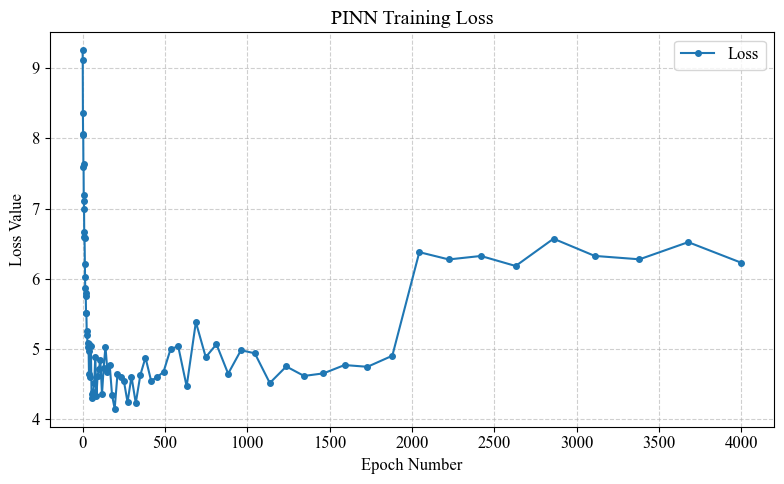

True and Predicted values of endpoints
True (x, y) final = (1.0065020322799683, 0.003258943557739258)
Pred (x, y) final = (4.994957447052002, 2.0437324047088623)
Mean Squared Error (X): 14.95675
Mean Squared Error (Y): 3.91359
Mean Absolute Error (X): 3.86395
Mean Absolute Error (Y): 1.97606
R-squared Score (X): -642.68683
R-squared Score (Y): -535.05963
Pearson Correlation (X): 0.01127
Pearson Correlation (Y): -0.11537
Cosine Similarity (X): 0.99100
Cosine Similarity (Y): 0.64539
Normalized RMSE (X): 8.87912
Normalized RMSE (Y): 8.17223


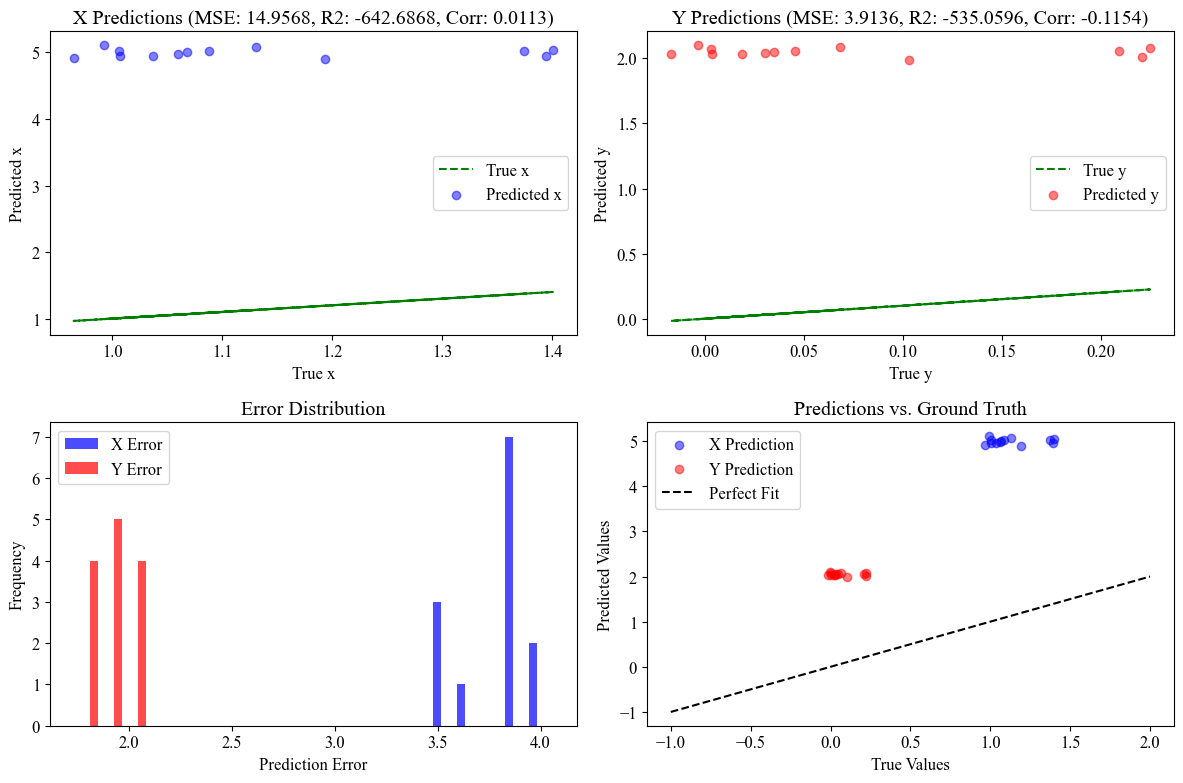

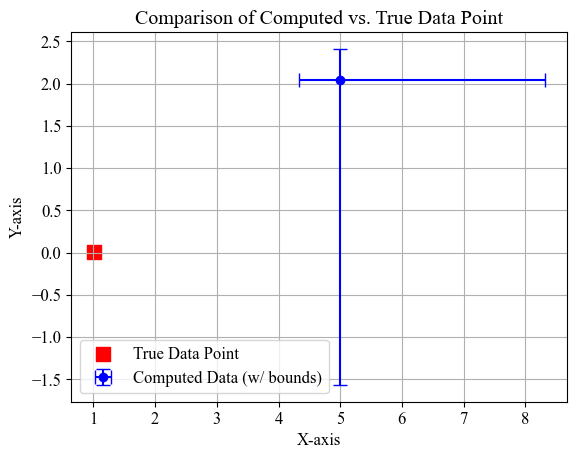

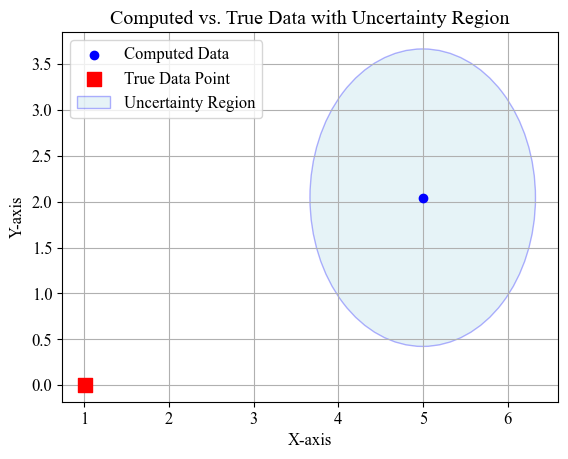

In [24]:
plot_nn_loss(trainer.total_loss_epoch, model_name="PINN")
print_stats_lastpt(mean_pred_np[:, 0], mean_pred_np[:, 1], 
                              x_test_sol, y_test_sol)
plot_comparison_lastpt(mean_pred_np[-1, :], 
                       lower_bound[-1], upper_bound[-1], 
                       (x_test_sol[-1], y_test_sol[-1]))

### Let's put the primary code into a run function

In [25]:
def run_train_test(threshold: float = 5.0, num_epochs: int = 4000, batch_size: int = 50):
    """ run_train_test function
    
    Args:
        threshold (float):  maximum time (seconds) to be used in training. 
                            Default is 5.0 seconds.
        num_epochs (int):   number of epochs for training. Default is 4000.
        batch_size (int):   training batch size for data loader. Default is 50.
    """
    # Modify dataset to exclude data above threshold
    train_dataset = PINNDataset(train_t, train_x, train_y, threshold=threshold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = PINN(hidden_size=64, output_size=2).to(torch.float32)
    optimizer = Adam(model.parameters(), lr=0.001)

    # Train model
    trainer = PINNTrainer(model, optimizer, train_loader, test_loader)
    trainer.train(num_epochs=num_epochs)

    # Predict missing data points with uncertainty
    t_future = torch.tensor(np.linspace(threshold, max(t_noisy), 50).reshape(-1, 1), dtype=torch.float32)
    mean_pred, std_pred = trainer.predict_with_uncertainty(t_future, num_samples=100)

    # Convert to numpy for analysis
    mean_pred_np = mean_pred.detach().numpy()
    std_pred_np = std_pred.detach().numpy()

    # Print the final predicted value with 80% confidence interval
    lower_bound = mean_pred_np - 1.28 * std_pred_np
    upper_bound = mean_pred_np + 1.28 * std_pred_np

    print("Final Prediction at max t:", mean_pred_np[-1])
    print("80% Confidence Interval:", (lower_bound[-1], upper_bound[-1]))
    plot_nn_loss(trainer.total_loss_epoch, model_name="PINN")



Epoch 0 Loss: 8.712227
Epoch 500 Loss: 4.749621
Epoch 1000 Loss: 4.638005
Epoch 1500 Loss: 4.646792
Epoch 2000 Loss: 4.784489
Epoch 2500 Loss: 6.228255
Epoch 3000 Loss: 6.373152
Epoch 3500 Loss: 6.572406
Epoch 4000 Loss: 6.521482
Epoch 4500 Loss: 6.325408
Epoch 5000 Loss: 6.422274
Epoch 5500 Loss: 6.373182
Epoch 6000 Loss: 6.228315
Epoch 6500 Loss: 6.276754
Epoch 7000 Loss: 6.373484
Epoch 7500 Loss: 6.325742
Epoch 8000 Loss: 6.373204
Epoch 8500 Loss: 6.421567
Epoch 9000 Loss: 6.325265
Epoch 9500 Loss: 6.325407
Epoch 10000 Loss: 6.324458
Epoch 10500 Loss: 6.520646
Epoch 11000 Loss: 6.325935
Epoch 11500 Loss: 6.470870
Epoch 12000 Loss: 6.373207
Epoch 12500 Loss: 6.324193
Epoch 13000 Loss: 6.520915
Epoch 13500 Loss: 6.519042
Epoch 14000 Loss: 6.278391
Epoch 14500 Loss: 6.324890
Epoch 15000 Loss: 6.373110
Epoch 15500 Loss: 6.277937
Epoch 16000 Loss: 6.421650
Epoch 16500 Loss: 6.373429
Epoch 17000 Loss: 6.325620
Epoch 17500 Loss: 6.231526
Epoch 18000 Loss: 6.229511
Epoch 18500 Loss: 6.32505

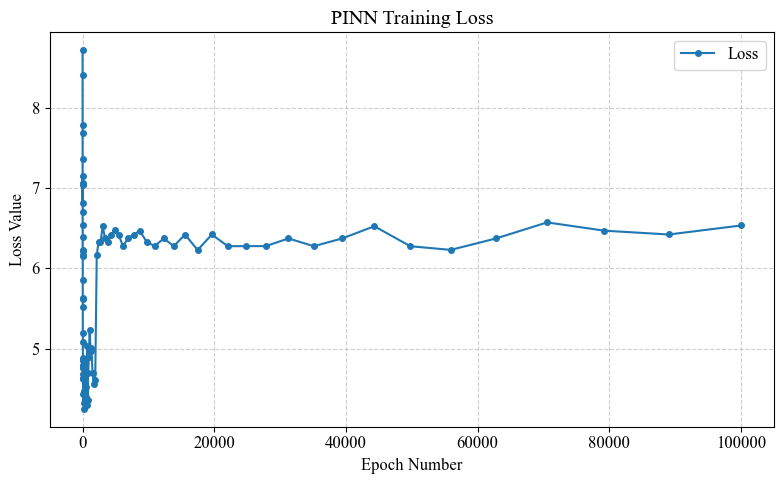

True and Predicted values of endpoints
True (x, y) final = (1.0065020322799683, 0.003258943557739258)
Pred (x, y) final = (4.239974498748779, 1.5923717021942139)
Mean Squared Error (X): 10.24125
Mean Squared Error (Y): 2.47646
Mean Absolute Error (X): 3.19588
Mean Absolute Error (Y): 1.57109
R-squared Score (X): -439.74799
R-squared Score (Y): -338.21048
Pearson Correlation (X): -0.11107
Pearson Correlation (Y): -0.01172
Cosine Similarity (X): 0.99081
Cosine Similarity (Y): 0.64650
Normalized RMSE (X): 7.34730
Normalized RMSE (Y): 6.50082


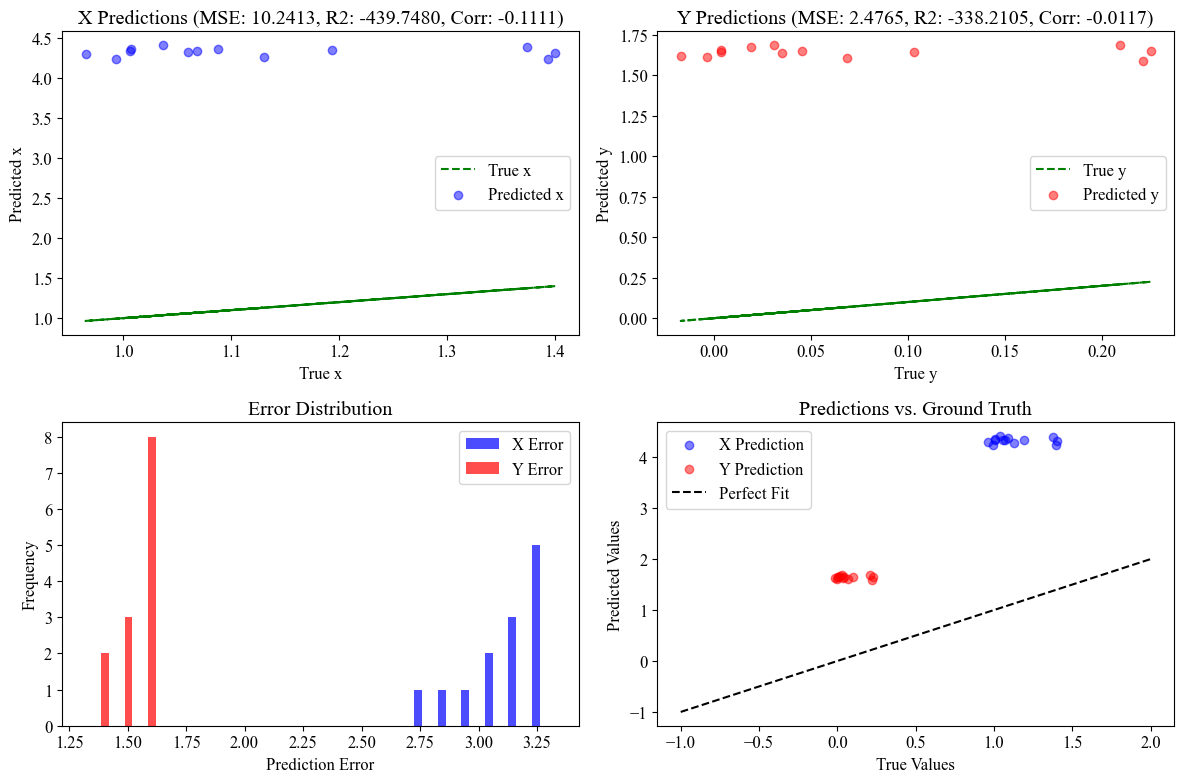

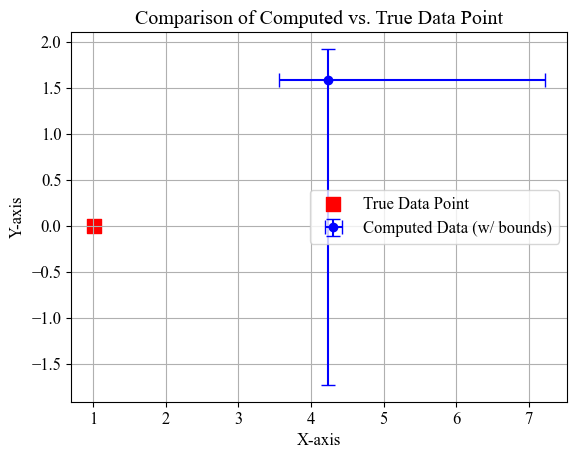

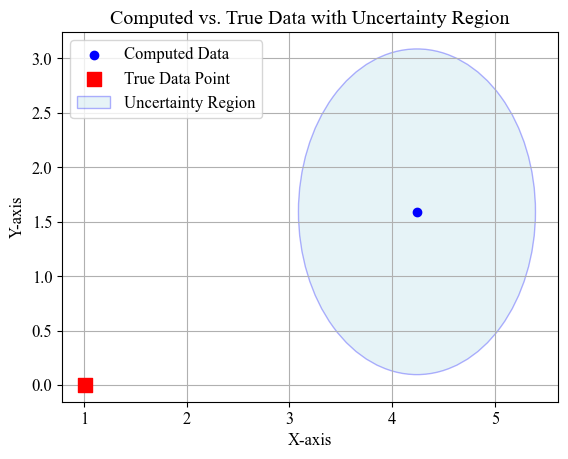

In [26]:
run_train_test(num_epochs=100000)
print_stats_lastpt(mean_pred_np[:, 0], mean_pred_np[:, 1], 
                              x_test_sol, y_test_sol)
plot_comparison_lastpt(mean_pred_np[-1, :], 
                       lower_bound[-1], upper_bound[-1], 
                       (x_test_sol[-1], y_test_sol[-1]))

## Use sequence sliding input window for allowed training data

We can do this now with `trainer.predict_with_uncertainty(self, t_test, num_samples=100)` where `num_samples` is the number of samples to include in the sliding. You can see this being called in `run_train_test` on this line,

```mean_pred, std_pred = trainer.predict_with_uncertainty(t_future, num_samples=100)```

and the resulting statistics and plots as shown in the previous cell.

## Use window data gap to ignore data in training

### Thresholding
We can do this now when the data loader is called as in the first line here with the `threshold` variable defined.  The `threshold` masks all data beyond the given threshold time.

```
train_dataset = PINNDataset(train_t, train_x, train_y, threshold=threshold)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
```

### Using Batch Sizes
The second line above allows the user to train in batches with the input variable `batch_size`.  This helps memory management during training for when the training dimensionality to too large to fit into resource memory.

### Shuffleing
The parameter `shuffle` in the DataLoader allows for the data to be shuffled. The structure of our current time series data does not warrant shuffling the data along the time domain.  Where as, if our data had many values for a particular value in time, then we would want to suffle the data.  

As a review on **shuffling** in machine learning, shuffling or randomizing the order of the training data serves several important purposes, which contribute to the model's robustness and effectiveness:

- Avoiding Overfitting: By introducing randomness into the training data, shuffling prevents the model from memorizing the exact sequence or order of examples. This avoids overfitting, where the model might learn to predict based on position rather than feature relationships.
- Equal Treatment of Examples: Each example is treated equally regardless of its position in the dataset. This ensures that the model doesn't rely on the specific order when making predictions, focusing instead on the inherent characteristics of the data.
- Generalization Performance: Shuffling exposes the model to varied permutations of the data, which improves generalization. The model learns to handle different input orders, leading to better performance on new, unseen data.
- Accurate Evaluation in Cross-Validation: Techniques like k-fold cross-validation rely on random subsets of data for each fold, ensuring that evaluations are based on representative and varied samples from the dataset.
- Handling Sequential Data: For data with inherent order dependencies (e.g., time series), shuffling can help break these dependencies, allowing the model to process each instance independently rather than as part of a sequence.
- Reproducibility and Robust Training Dynamics: Using random seeds alongside shuffling ensures reproducibility by controlling variability in the training data across different runs, while introducing noise during training can prevent co-adaptation with input sequences.

In summary, shuffling ensures that the model's learning process is based on the content of the examples rather than their order, leading to more robust and generalizable models.

# Example Graph represent probabilities

/var/folders/bj/ncr1n7_13gv1_cr07lsbnl7h0000gn/T/ipykernel_5702/3109742726.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


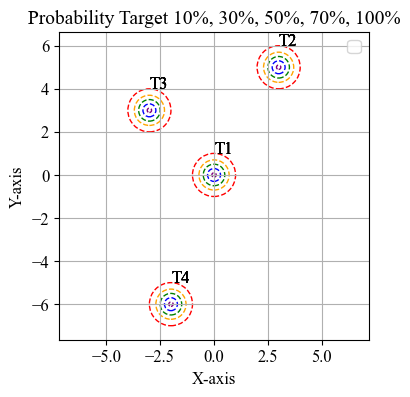

In [26]:
# Create a figure with an 8x8 inch size
plt.figure(figsize=(4, 4))
ax = plt.gca()#axes()#([0.05, 0.05, 1, 1])

# Define radii for each probability level (as fractions of the unit circle)
radii = [0.1, 0.3, 0.5, 0.7, 1.0]

# Assign colors to each circle
colors = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#ff00ff']
color_map = {
    0.1: 'purple',
    0.3: 'blue',
    0.5: 'green',
    0.7: 'orange',
    1.0: 'red'
}
xy_circles = [(0,0), (3,5), (-3,3), (-2, -6)]
xy_names = ['T1', 'T2', 'T3', 'T4']

# change default range so that new circles will work
ax.set_xlim((min([c[0] for c in xy_circles])-radii[-1]-radii[0], 
             max([c[0] for c in xy_circles])+radii[-1]+radii[0]))
ax.set_ylim((min([c[1] for c in xy_circles])-radii[-1]-radii[0], 
             max([c[1] for c in xy_circles])+radii[-1]+radii[0]))

for n in range(len(xy_circles)):
    for r in radii:
        # Draw each circle as a dashed line outline without filling
        circle = plt.Circle(xy_circles[n], r, linestyle='--', fill=False, color=color_map[r])#edgecolor=colors[radii.index(r)])
        ax.add_patch(circle)
        plt.text(xy_circles[n][0], xy_circles[n][1]+radii[-1], xy_names[n])

# Set background colors for a clean look
ax.set_facecolor('white')
ax.axis('equal')

# Add labels and title
mytitle = "Probability Target"
for r in radii:
    mytitle+=f" {(r*100):.0f}%,"
mytitle=mytitle[:-1]
plt.title(mytitle, fontsize=14)
plt.grid()
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display the graph
# plt.savefig('cicles.png')
plt.show()


## Expand last point prediction to area prediction
Now we want to change the objective from predicting the end-point or predicting a label of the end-point to predicting and end-point that falls within a certain area.

# Perform 2-class classification for last point prediction
Now we want to change the objective from predicting the end-point to predicting a label, such as the name of the end-point.
